<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/Hospital_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools
import matplotlib.pyplot as plt
#!pip install protobuf
#!pip install --upgrade protobuf

In [ ]:
from ortools.sat.python import cp_model
import numpy as np
import calendar
import random
random.seed(42)
#plt.rcParams["figure.figsize"] = (15,10)

In [ ]:

# Parameters
n_days = 30
start_day = 0  # 0=Monday, 6=Sunday
n_workers = 15
n_shifts = 3
# Map days
weekdays = list(calendar.day_name)  # ['Monday', 'Tuesday', ..., 'Sunday']
day_to_weekday = {day: weekdays[(start_day + day - 1) % 7] for day in range(n_days)}

# Print mapping
for d, w in day_to_weekday.items():
    print(f"Day {d}: {w}")



Day 0: Sunday
Day 1: Monday
Day 2: Tuesday
Day 3: Wednesday
Day 4: Thursday
Day 5: Friday
Day 6: Saturday
Day 7: Sunday
Day 8: Monday
Day 9: Tuesday
Day 10: Wednesday
Day 11: Thursday
Day 12: Friday
Day 13: Saturday
Day 14: Sunday
Day 15: Monday
Day 16: Tuesday
Day 17: Wednesday
Day 18: Thursday
Day 19: Friday
Day 20: Saturday
Day 21: Sunday
Day 22: Monday
Day 23: Tuesday
Day 24: Wednesday
Day 25: Thursday
Day 26: Friday
Day 27: Saturday
Day 28: Sunday
Day 29: Monday



*   No one works back-to-back shifts (because sleep is kind of important).
*   Night shifts are limited to 4 per month per worker (we’re not running a vampire clinic).
*   Weekends (Saturdays & Sundays) must be evenly covered—no dumping all the worst shifts on the newbie.
*   Each shift needs at least 2 workers (because one person alone in a night shift is just asking for horror movie tropes).

In [ ]:
model = cp_model.CpModel()
solver = cp_model.CpSolver()
shifts = ['M','A','N']
days = [d for d in range(n_days)]
workers = [w for w in range(1, 1+n_workers)]
preferance = {(w,s):random.randint(1,3) for s in shifts for w in workers}

U = {(w,s,d):model.NewBoolVar(f"assign_{w}_{s}_{d}")  for w in workers for d in days for s in shifts}

for d in days:
  for s in shifts:
    model.Add(sum(U[w,s,d] for w in workers) == 2)

for w in workers:
  for d in days:
    model.Add(sum(U[w,s,d] for s in shifts) <= 1)

for w in workers:
  model.Add(sum(U[w,'N',d] for d in days) <= 4)

for w in workers:
  for d in days:
    if d+1 in days:
      model.Add(U[w,'N',d] + U[w,'M',d+1]  <= 1)
      model.Add(U[w,'N',d] + U[w,'N',d+1]  <= 1)


not_same_shift = [(9,8)]

minscore = model.NewIntVar(0,200,'min_score')
maxscore = model.NewIntVar(0,200,'max_score')

for w in workers:
  a = sum([U[w,s,d] for d in days for s in shifts if day_to_weekday[d] in ['Saturday', 'Sunday']])
  model.Add(a <= 4)
  model.Add(a >= 2)
  expr = [preferance[w,s]*U[w,s,d] for d in days for s in shifts]
  model.Add(minscore <= sum(expr))
  model.Add(maxscore >= sum(expr))

for (w1,w2) in not_same_shift:
  for d in days:
    for s in shifts:
      model.Add(U[w1,s,d] + U[w2,s,d] <= 1)


for w1 in workers:
  for w2 in workers:
    if w1 > w2:
        a1 = sum([U[w1,s,d] for d in days for s in shifts])
        a2 = sum([U[w2,s,d] for d in days for s in shifts])
        model.Add(a1 - a2 <= 2)
        model.Add(a2 - a1 <= 2)
        #pass

for w in workers:
  for d in days:
    if d+6 in days:
      pass
        # model.Add(sum(U[w,s,dd] for dd in range(d,d+7) for s in shifts) <= 5)
        #model.Add(sum(U[w,s,dd] for dd in range(d,d+7) for s in shifts) >= 3)

model.Minimize(maxscore-minscore)


# Maximize x
#expressions = [v*dist(i,j,df) for (i,j),v in U.items() ]
#model.Minimize(sum(expressions))
#model.Maximize(minscore)



solver.parameters.max_time_in_seconds = 60
stat = solver.Solve(model)
print( solver.status_name(stat) )
print(solver.ObjectiveValue(), solver.value(maxscore) , solver.value(minscore))

OPTIMAL
12.0 25 13


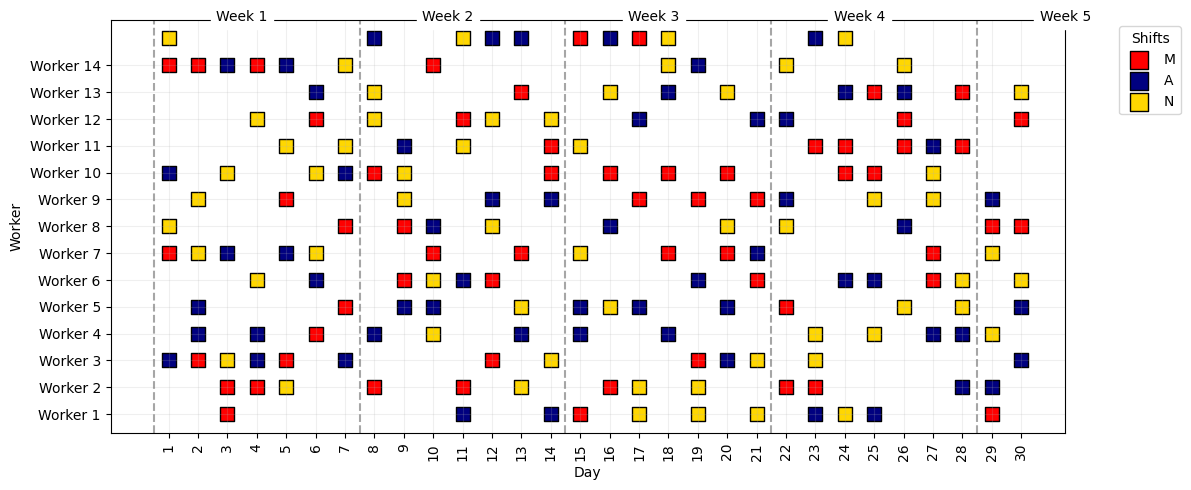

In [ ]:
U_values = {}
shift_color = {'M':'r','A':'navy','N':'gold'}

# --- Visualization with scatter ---
plt.figure(figsize=(12, 5))

for (w,s,d),v in U.items():
  if solver.value(v):
    plt.scatter(d + 1, w, c=shift_color[s], s=100, marker="s", edgecolors="black")

plt.xticks(range(1, n_days + 1), rotation=90)
plt.yticks(range(n_workers), [f"Worker {w}" for w in range(n_workers)])
plt.xlabel("Day")
plt.ylabel("Worker")
#plt.title("Shift Assignments ")
for week in range(0, n_days + 1, 7):
    plt.axvline(x=week + 0.5, color='gray', linestyle='--', alpha=0.7)
    if week < n_days:
        plt.text(week + 3.5, n_workers + 0.8, f'Week {week//7 + 1}',
                ha='center', va='center', backgroundcolor='white')

# Legend for shifts
for s,kolor in shift_color.items():
    plt.scatter([], [], c=kolor, s=150, marker="s", edgecolors="black", label=s)
plt.legend(title="Shifts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha= 0.2)
plt.tight_layout()
plt.show()

1 25 4
2 13 4
3 17 4
4 23 4
5 19 4
6 13 2
7 19 4
8 25 4
9 24 4
10 21 4
11 25 4
12 25 4
13 25 2
14 21 3
15 25 3


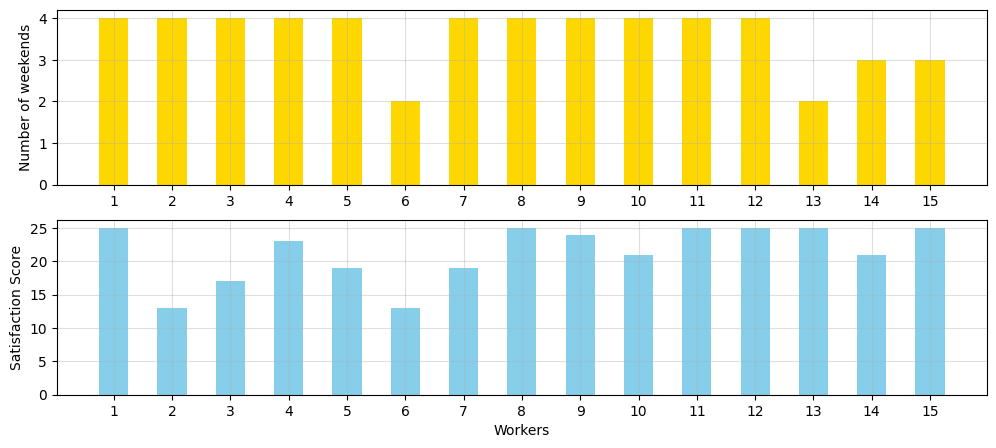

# of Weekend max 4 , min 2
Score max 25 , min 13


In [ ]:
plt.figure(figsize=(12, 5))

y1, y2 = [], []
for w in workers:
  a = sum([solver.value(U[w,s,d]) for d in days for s in shifts if day_to_weekday[d] in ['Saturday', 'Sunday']])
  score = sum([solver.value(preferance[w,s]*U[w,s,d]) for d in days for s in shifts])
  y1.append(a)
  y2.append(score)

  print(w,score, a)

plt.subplot(2,1,1)
plt.bar(workers, y1,width=0.5, facecolor = 'gold')
plt.ylabel('Number of weekends')
plt.grid(alpha=0.4)

plt.xticks(workers)
plt.subplot(2,1,2)

plt.bar(workers, y2,width=0.5, facecolor = 'skyblue')
plt.xticks(workers)
plt.xlabel('Workers')
plt.ylabel('Satisfaction Score')
plt.grid(alpha=0.4)
plt.show()
print(f'# of Weekend max {max(y1)} , min {min(y1)}')
print(f'Score max {max(y2)} , min {min(y2)}')


In [ ]:
preferance

{(1, 'M'): 3,
 (2, 'M'): 1,
 (3, 'M'): 1,
 (4, 'M'): 3,
 (5, 'M'): 2,
 (6, 'M'): 1,
 (7, 'M'): 1,
 (8, 'M'): 1,
 (9, 'M'): 3,
 (10, 'M'): 1,
 (11, 'M'): 3,
 (12, 'M'): 3,
 (13, 'M'): 3,
 (14, 'M'): 1,
 (15, 'M'): 3,
 (1, 'A'): 2,
 (2, 'A'): 1,
 (3, 'A'): 1,
 (4, 'A'): 1,
 (5, 'A'): 1,
 (6, 'A'): 1,
 (7, 'A'): 3,
 (8, 'A'): 3,
 (9, 'A'): 1,
 (10, 'A'): 3,
 (11, 'A'): 1,
 (12, 'A'): 3,
 (13, 'A'): 3,
 (14, 'A'): 3,
 (15, 'A'): 3,
 (1, 'N'): 2,
 (2, 'N'): 1,
 (3, 'N'): 2,
 (4, 'N'): 3,
 (5, 'N'): 2,
 (6, 'N'): 1,
 (7, 'N'): 1,
 (8, 'N'): 3,
 (9, 'N'): 2,
 (10, 'N'): 2,
 (11, 'N'): 2,
 (12, 'N'): 1,
 (13, 'N'): 1,
 (14, 'N'): 2,
 (15, 'N'): 1}

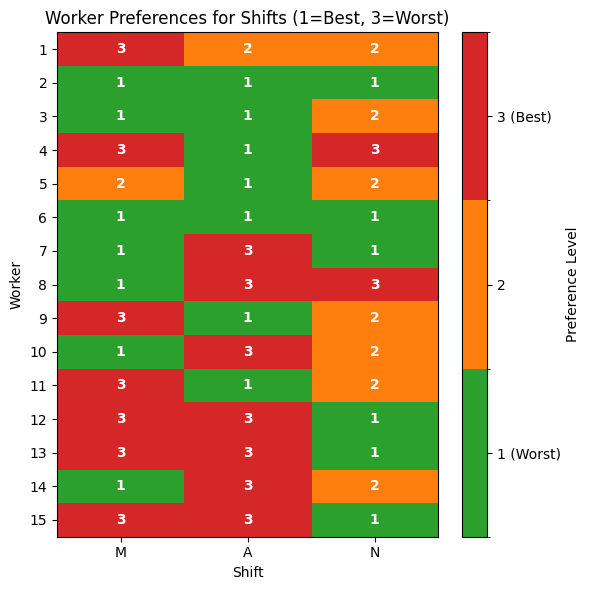

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Build matrix
hifts = ['M', 'A', 'N']

# Build matrix
matrix = np.array([[preferance[(w, s)] for s in shifts] for w in workers])

# Discrete colormap (3 levels)
colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # green=1, orange=2, red=3
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 6))
im = plt.imshow(matrix, cmap=cmap, norm=norm, aspect="auto")

# Labels
plt.xticks(ticks=np.arange(len(shifts)), labels=shifts)
plt.yticks(ticks=np.arange(len(workers)), labels=workers)
plt.xlabel("Shift")
plt.ylabel("Worker")
plt.title("Worker Preferences for Shifts (1=Best, 3=Worst)")

# Discrete colorbar
cbar = plt.colorbar(im, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(["1 (Worst)", "2", "3 (Best)"])
cbar.set_label("Preference Level")

# Show values in cells
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, matrix[i, j],
                 ha="center", va="center", color="white", weight="bold")

plt.tight_layout()
plt.show()
